# Step matrix

## Step matrix intro

Step matrix is a very powerful tool in retentioneering arsenal. It allows to get quickly high-level understing of user behaviour. Step matrix has powerful customization options to tailor the output depending the goal of the analysis.

To better understand how step_matrix works let’s first consider intuitive example. Let’s say we are analyzing web-store logs and have dataset with event logs from four user sessions with the following events in following order:

In [1]:
# @TODO: Paste image. jostanina

We can visualize this dataset as a heatmap indicating what fraction of users were at wich step in their trajectories:

This is the simplest step matrix. It has individual unique events as a rows, columns corresponds to the positional number of event in user log and the value in the matrix shows what percentage users have given event at a given step. Note, that total value in each column is always 1 (all users must be at specific state at each step or have ENDED their trajectory).

Below we will explore how to plot and customize step matrix.

Install retentioneering if running from google.colab or for the first time:

In [2]:
 #!pip install retentioneering

## Basic example

   In order to start, we need to:
    - `import retentioneering`,
    - load sample dataset
    - create `eventstream` object @TODO: Link to explanation of eventstream. dpanina.


In [3]:
import sys
import pandas as pd
sys.path.insert(0, '..')

In [4]:
# import retentioneering
from src.eventstream import Eventstream, EventstreamSchema, RawDataSchema

#from src.datasets.data import simple-onlineshop.csv
# load sample user behavior data as a pandas dataframe:
raw_data = pd.read_csv('../src/datasets/data/simple-onlineshop.csv')   #TODO: прописать загрузку нормально. j.ostanina

# create data schema
raw_data_schema = RawDataSchema(
    event_name="event", event_timestamp="timestamp", user_id="user_id")

# create source eventstream
source = Eventstream(
    raw_data=raw_data,
    raw_data_schema=raw_data_schema,
    schema=EventstreamSchema()
)

/Users/j.ostanina/miniforge3/envs/rete_tools/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There are two ways to plot step matrix using retentioneering:
1) To create instance of a class StepMatrix

<AxesSubplot: title={'center': ' step matrix '}>

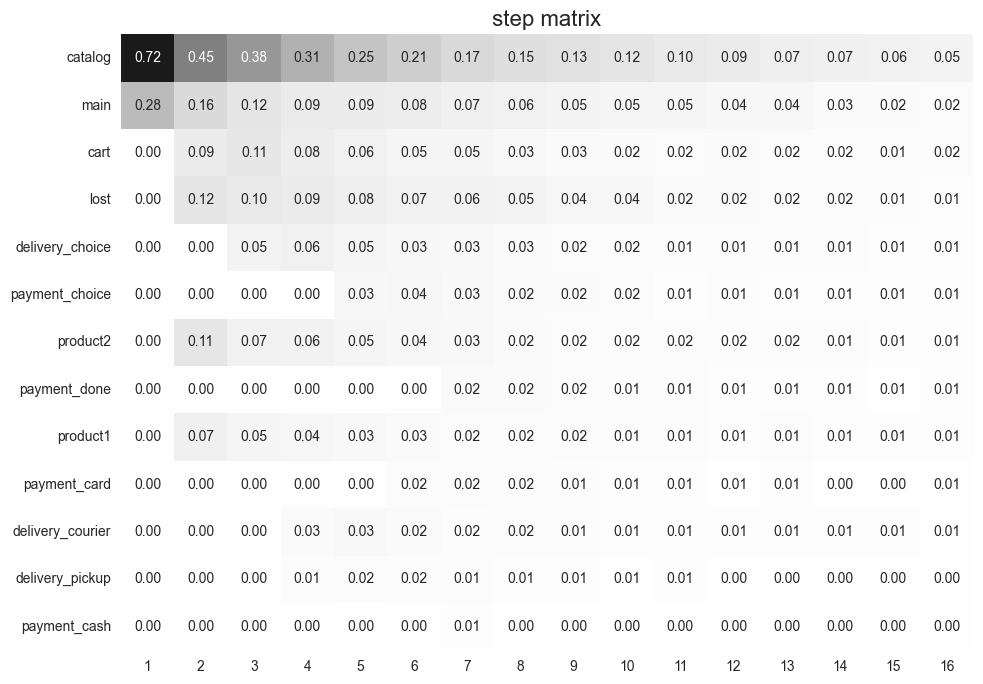

In [5]:
from src.tooling.step_matrix import StepMatrix

step_matrix = StepMatrix(
    eventstream=source,
    max_steps=16
    )
step_matrix.plot()

2) To call an eventstream method eventstream.step_matrix()
Further in this tutorial we will use exactly this method

<AxesSubplot: title={'center': ' step matrix '}>

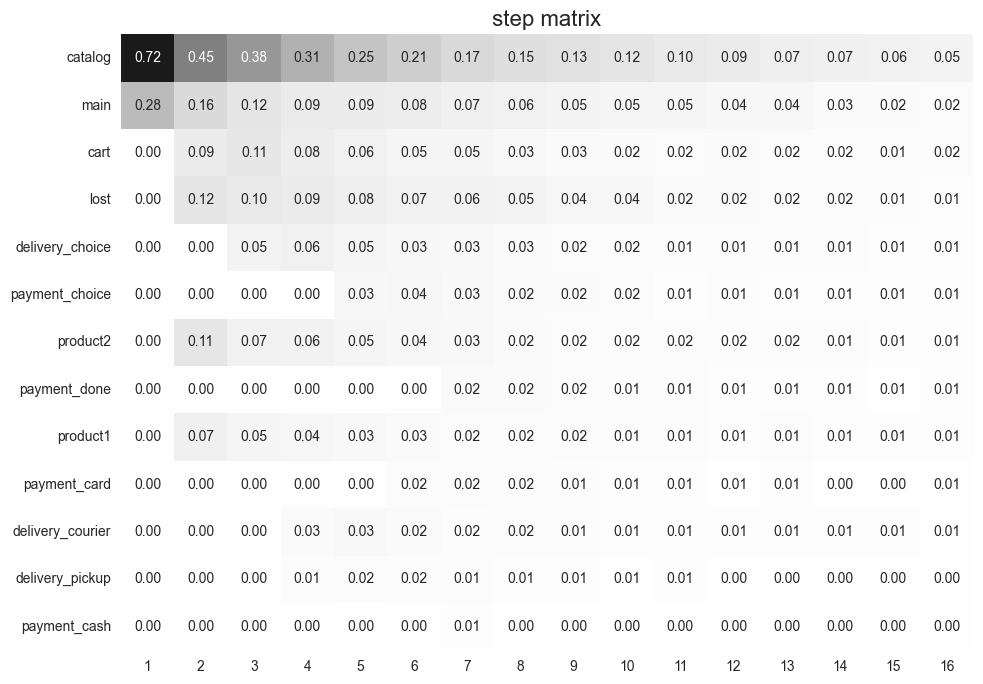

In [6]:
source.step_matrix(max_steps=16)

To understand intuitively what is step_matrix let us begin with plotting step_matrix for extremely simple dataset containing events for only one user:

In [7]:
single_user = raw_data[raw_data['user_id'] == 613604495].reset_index(drop=True)
single_user

,user_id,event,timestamp
0,613604495,main,2019-11-02 23:25:03.672939
1,613604495,catalog,2019-11-02 23:25:07.390498
2,613604495,catalog,2019-11-02 23:25:48.043605
3,613604495,product2,2019-11-02 23:26:08.845033
4,613604495,cart,2019-11-02 23:26:37.007346
5,613604495,catalog,2019-11-02 23:26:38.406224
6,613604495,cart,2019-11-02 23:27:09.279245
7,613604495,catalog,2019-11-02 23:27:11.432713
8,613604495,product2,2019-11-02 23:27:43.193619
9,613604495,cart,2019-11-02 23:27:48.110186


Don't forget to create an Eventstream:

In [8]:
single_user_evs = Eventstream(
    raw_data=single_user,
    raw_data_schema=raw_data_schema,
    schema=EventstreamSchema()
)

Let’s plot a simple intuitive step_matrix for our single user dataset:

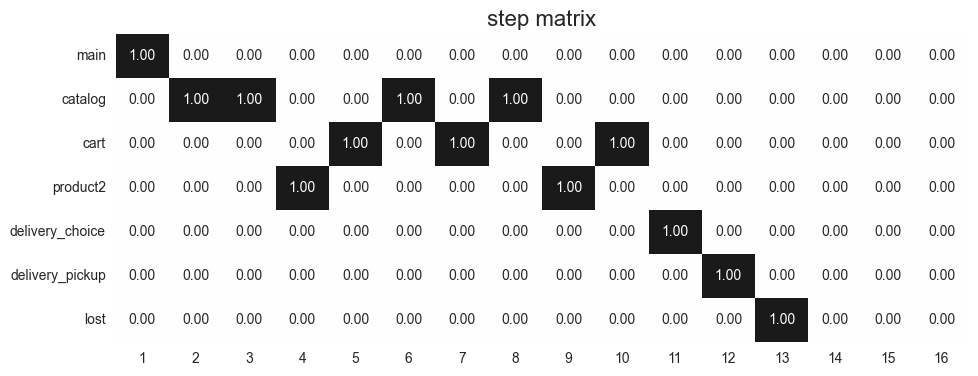

In [9]:
single_user_evs.step_matrix(max_steps=16);

As we can see, since we have only one user in this example, step_matrix contains only 0’s and 1’s. At step 1 user had event "main" (100% of users have event main as the first event in the trajectory), then at step 2 user proceeded to catalog etc. By step 13 user’s trajectory ended and there are no more events, so the rest of the table is filled with zeros.

Let’s now plot step_matrix for the full dataset containing all users:

<AxesSubplot: title={'center': ' step matrix '}>

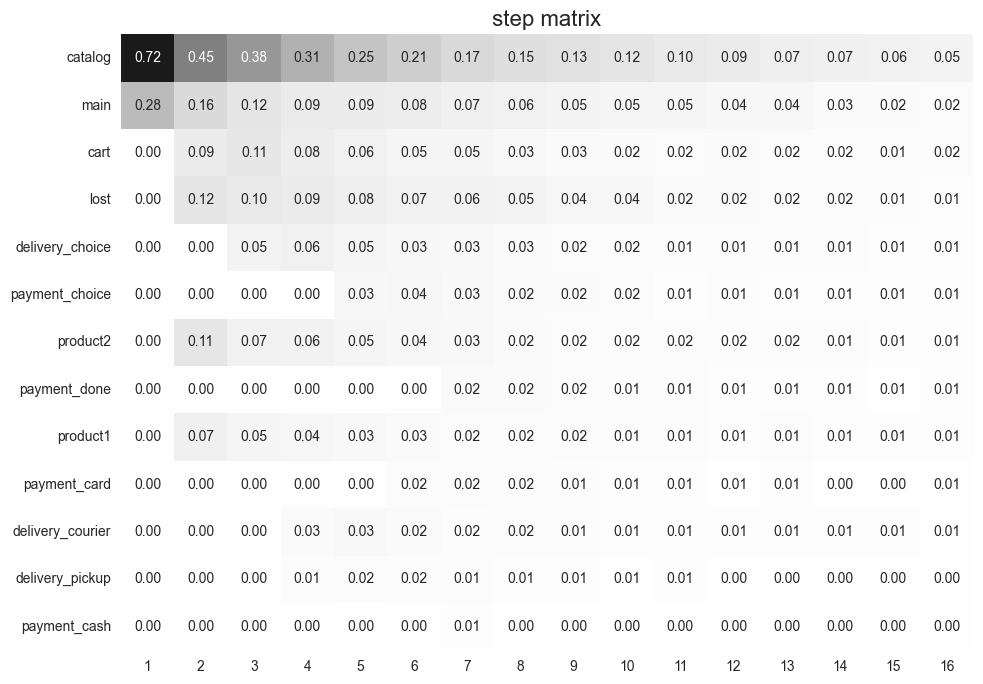

In [10]:
source.step_matrix(max_steps=16)

By looking at the first column we can immediately say that users in the analyzed cohort start their sessions from events catalog (72%) and main (28%). At step 2 12% of users already ended their sessions and have no other events (row ENDED at step 2 is 0.12). We can see, that 52% of users finish their sessions with 6 or less events (row ENDED at step 7 is 0.52). Some conversions start happening after step 7 (row payment_done have 0.02 at step 7). And so on. Note, that at each step all values in every column always sum up to 1 (meaning that all users have some specific event or ENDED state). Below we will explore other options for step_matrix function to make the output much more informative and tailored for the goals of particular analysis.

## Thresholding

When we plot step_matrix using full dataset sometimes we want first focus on bigger picture and avoid rows with event where insignificant fraction of users was present. Such thresholding can be done using thresh parameter (float, default: 0). If the row has all values less than specified thresh, such row will not be shown.

<AxesSubplot: title={'center': ' step matrix '}>

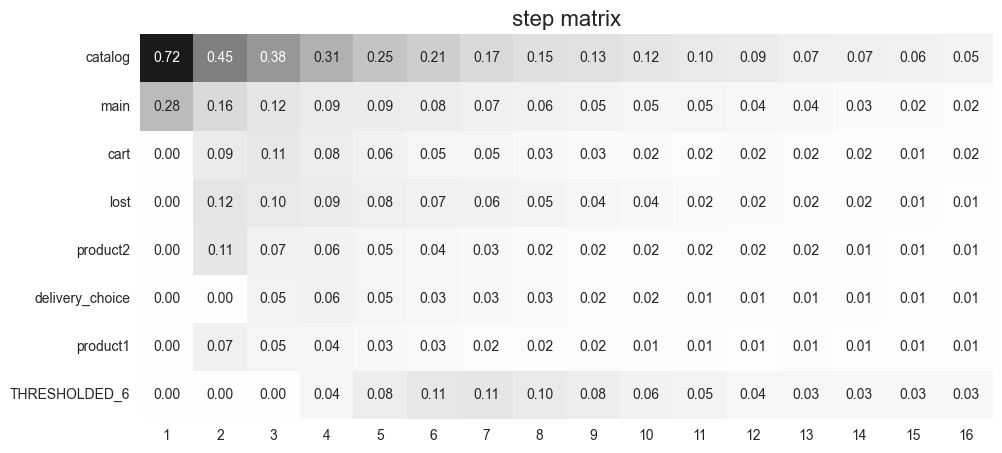

In [17]:
source.step_matrix(max_steps=16,
                      thresh=0.05)

All events cutted away by thresholding are grouped together in THRESHOLDED_X row, where X - is the total number of dropped events.

## Targets analysis

Very often there are specific events of particular importance for product analyst (for example such as cart, or order_confirmed, or subscribe, etc.). Often such events have much lower occurrence rate comparing other events (like main page or catalog) and often ended up thresholded from step_matrix or shown with non-informative coloring. In this case we can isolate those events of particular importance (targets) to individual rows, each of which will have their individual color scale. This can be done with parameter targets:

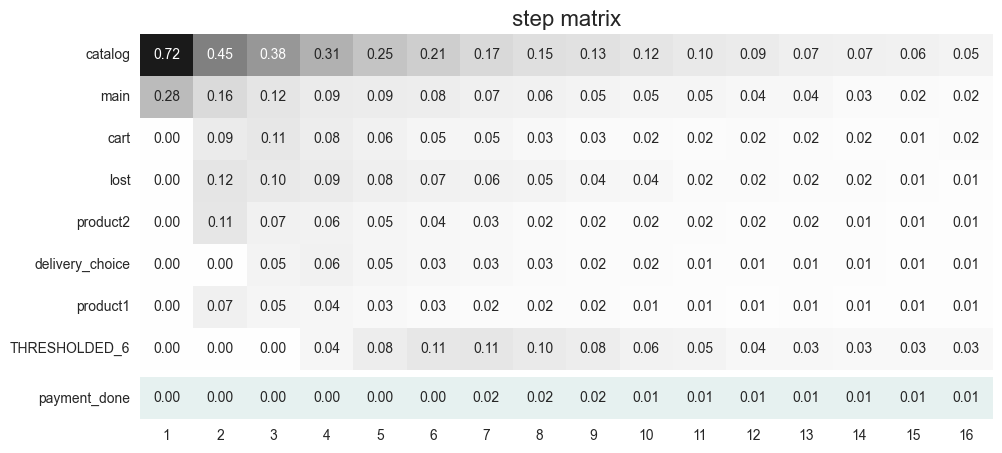

In [18]:
source.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['payment_done']);

Specified target events are always shown in the bottom of step matrix regardless of selected threshold. Multiple targets can be included as a list:

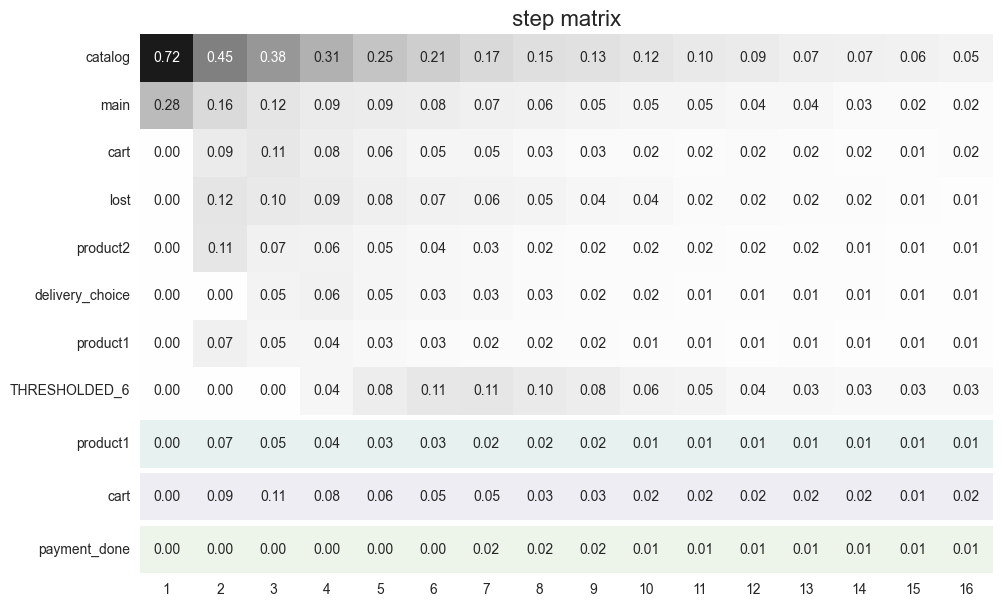

In [12]:
source.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1','cart','payment_done']);

If we want to compare some targets and plot them using same color scaling, we can combine them in sub-list inside the targets list:

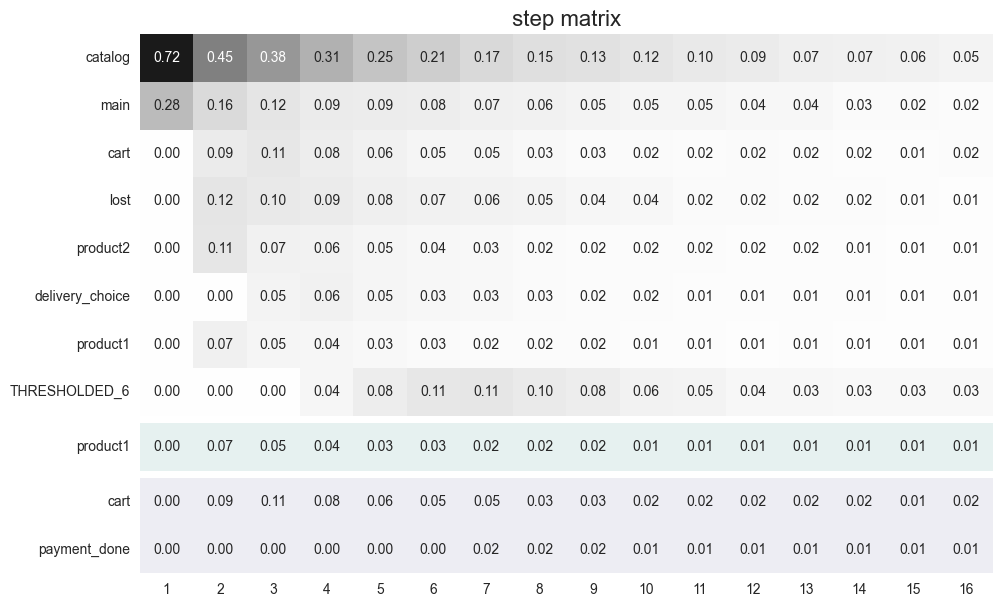

In [13]:
source.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']]);

Now we can visually compare by color how many users reach cart vs payment_done at particular step in their trajectory.

Targets can be presented as accumulated values (or both):

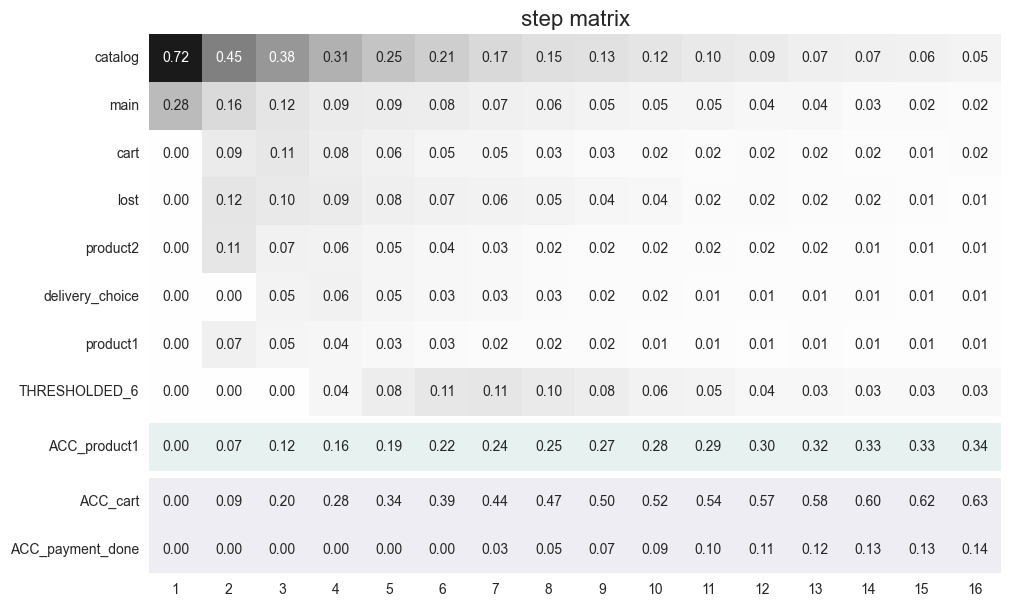

In [14]:
source.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']],
                      accumulated='only');

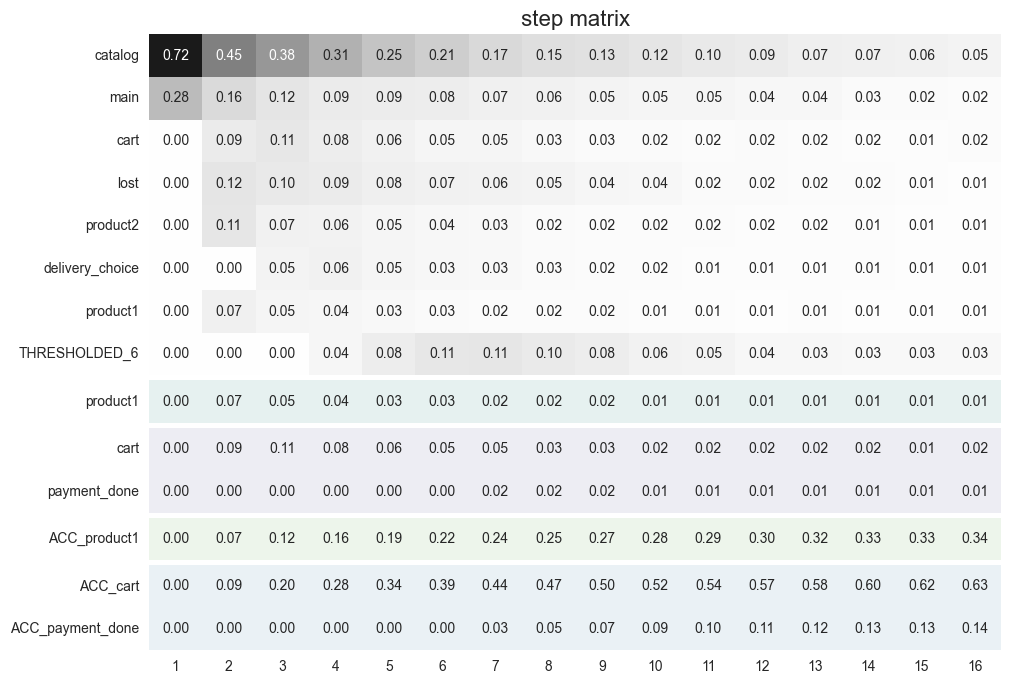

In [15]:
source.step_matrix(max_steps=16,
                      thresh=0.05,
                      targets=['product1',['cart','payment_done']],
                      accumulated='both');

## Centered step matrix

Sometimes we are interested in flow of users through specific event: how do users reach specific event and what do they do after? This information can be visualized with step_marix using parameter centered:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/examples/../src/tooling/step_matrix/step_matrix.py:276: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(self.weight_col).apply(self._pad_to_center)  # type: ignore


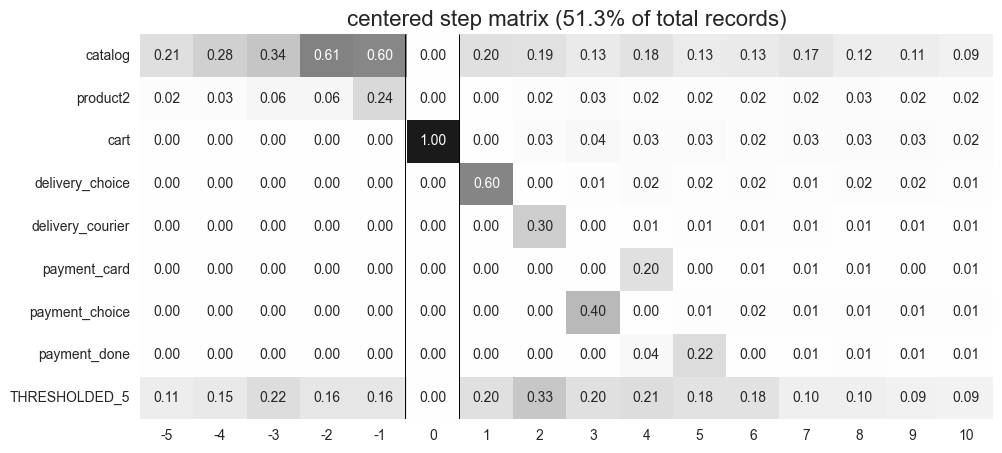

In [19]:
source.step_matrix(max_steps=16,
                      thresh = 0.2,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1});

Note, that when plotting step_matrix with parameter centered we only keep users who have reached the specified event (column 0 has value 1 at the specified event). Parameter centered is a dictionary which requires three keys:

* ‘event’ - the name of the event we are interested in. This event will be taken as 0. Negative step numbers will correspond to events before the selected event and positive step numbers will correspond to steps after the selected event

* ‘left_gap’ - integer number which indicates how many steps before the centered event we want to show on the step matrix

* ‘occurrence’ - which occurrence number of target event we are interested in. For example, in the illustration above, all trajectories will be aligned to have the first ‘cart’ occurrence as step 0

Importantly, when a centered step matrix is used, only users who have selected events in their trajectories present (or it’s n`th occurrence) will be shown. Therefore, the column with step index 0 will always have 1 at the selected event and zero at all other events. The fraction of users kept for the centered step matrix is shown in the title. In the example above, 51.3% of users have reached the event ‘cart’ at least once.

We can use all targets functionality with centered step_matrix, for example:

/Users/j.ostanina/Rete/retentioneering-tools-new-arch/examples/../src/tooling/step_matrix/step_matrix.py:276: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(self.weight_col).apply(self._pad_to_center)  # type: ignore


array([<AxesSubplot: title={'center': 'centered step matrix (51.3% of total records)'}>,
       <AxesSubplot: >], dtype=object)

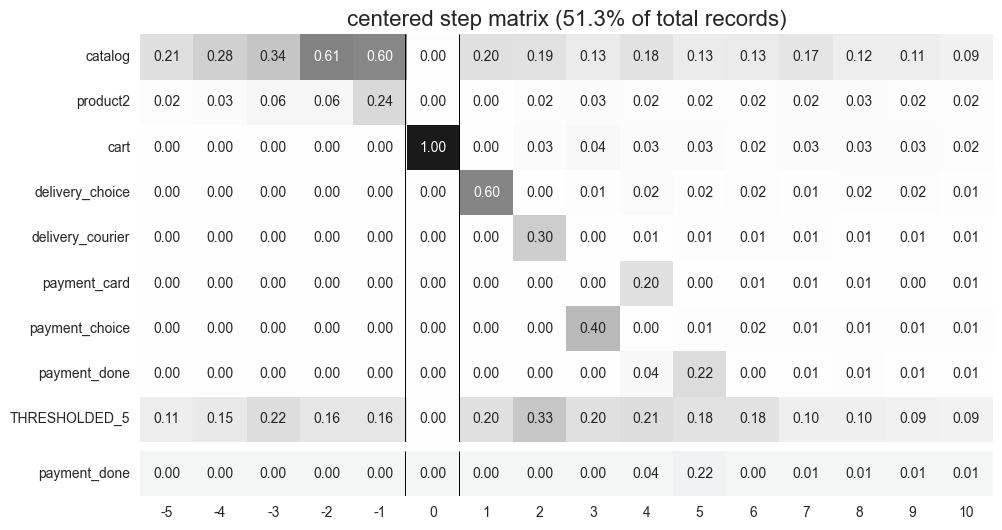

In [21]:
source.step_matrix(max_steps=16,
                      thresh = 0.2,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                      targets=['payment_done'])

## Custom events sorting

Sometimes it is needed to obtain step_matrix with events listed in the specific order (for example, to compare two step_matrixes). This can be done with parameter sorting which accepts a list of event names in the required order to show up in the step matrix. Let’s consider an example:

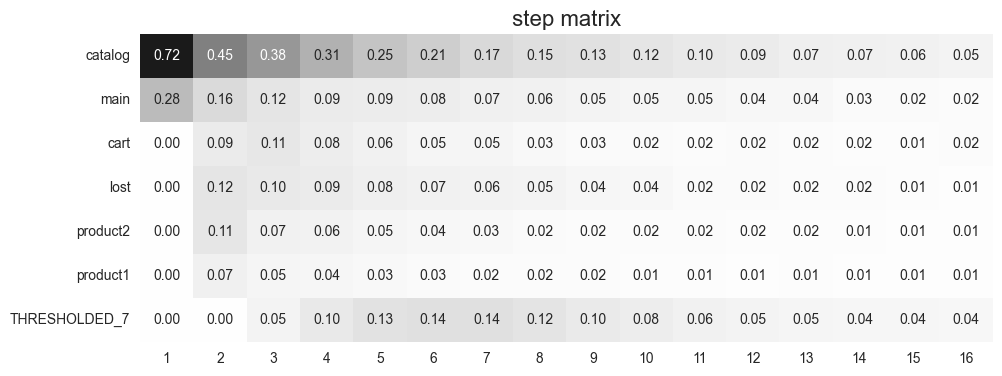

In [22]:
source.step_matrix(max_steps=16,
                      thresh=0.07);

Let’s say we would like to change the order of the events in the resulted step_matrix. First, we can obtain list of event names from the step_matrix output using a StepMatrix class method _get_plot_data() and .index:

In [23]:
step_matrix = StepMatrix(
    eventstream=source,
    max_steps=16,
    thresh=0.07)
step_matrix._get_plot_data()[0].index

Index(['catalog', 'main', 'cart', 'lost', 'product2', 'product1',
       'THRESHOLDED_7'],
      dtype='object')

Now we can conveniently copy the list of events, reorganize it in the required order and pass it to the step_matrix function as a sorting parameter:

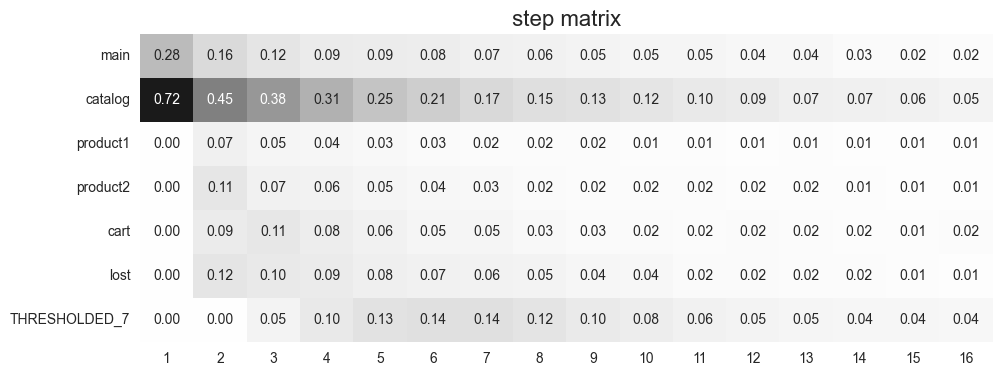

In [24]:
custom_order = ['main',
                'catalog',
                'product1',
                'product2',
                'cart',
                'lost',
                'THRESHOLDED_7']
source.step_matrix(max_steps=16,
                      thresh=0.07,
                      sorting=custom_order);

Note, that ordering only affects non-target events. Target events will always be in the same order as they are specified in the parameter targets.

## Differential step_matrix

Sometimes we need to compare the behavior of several groups of users. For example, when we would like to compare the behavior of users who had a conversion to target vs. those who had not, compare the behavior of test and control groups in the A/B test, or compare behavior between specific segments of users.

In this case, it is informative to plot a step_matrix as the difference between step_matrix for group_A and step_matrix for group_B. This can be done using parameter groups, which require a tuple of two elements (g1 and g2): where g_1 and g_2 are collections of user_id`s (list, tuple, or set). Two separate step_matrixes M1 and M2 will be calculated for users from g_1 and g_2, respectively. The resulting matrix will be the matrix M = M1-M2. Note, that values in each column in the differential step matrix will always sum up to 0 (since columns in both M1 and M2 always sum up to 1).


In [ ]:
g1 = set(raw_data[raw_data['event']=='payment_done']['user_id'])
g2 = set(raw_data['user_id']) - g1

source.step_matrix(max_steps=16,
                      thresh = 0.05,
                      centered={'event':'cart',
                                'left_gap':5,
                                'occurrence':1},
                      groups=(g1, g2));